## Peptide–MHC Visualization Notebook

This notebook generates two key plots for analyzing MHCflurry results:

Volcano-style plot on all predictions.csv, highlighting peptides that pass the filtering thresholds (IC50 < 500 nM or Percentile < 2%).


In [8]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = True


## Load data

In [9]:

pred_path = "predictions.csv"
strong_path = "strong_peptides.xlsx"


pred = pd.read_csv(pred_path)
strong = pd.read_excel(strong_path)

pred.head(), strong.head()


(       peptide       allele  mhcflurry_affinity  \
 0     AAAAAAAA  HLA-A*02:01        27700.018716   
 1    AAAAAAAAA  HLA-A*02:01         3875.857988   
 2   AAAAAAAAAA  HLA-A*02:01        10257.503498   
 3  AAAAAAAAAAA  HLA-A*02:01        11456.913484   
 4  AAAAAAAAAAV  HLA-A*02:01         5684.650058   
 
    mhcflurry_affinity_percentile  mhcflurry_processing_score  \
 0                      28.874250                    0.011204   
 1                       3.079875                    0.014406   
 2                       5.542500                    0.021116   
 3                       6.074875                    0.140801   
 4                       3.775000                    0.042643   
 
    mhcflurry_presentation_score  mhcflurry_presentation_percentile  
 0                      0.003786                          99.286603  
 1                      0.025309                           9.494239  
 2                      0.010226                          22.192310  
 3            

## 1) Volcano-style plot (all predictions, highlight = your filter)

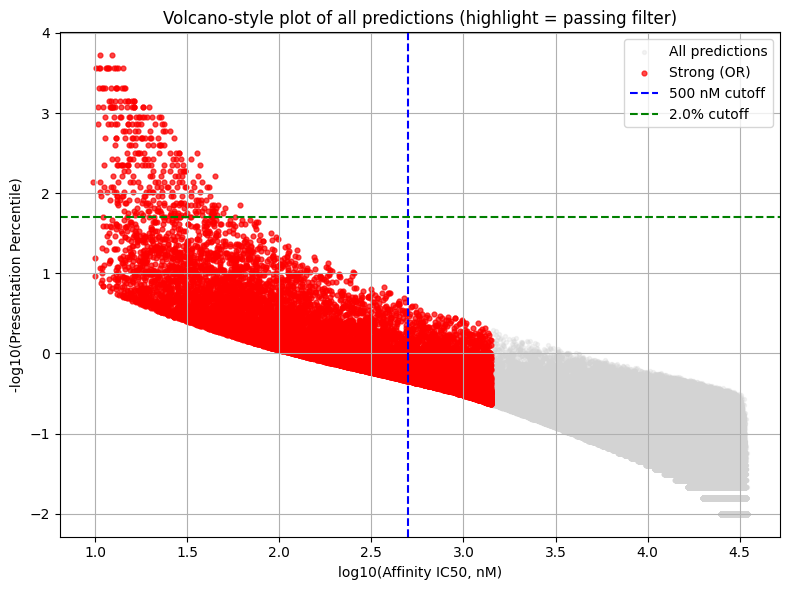

In [10]:

AFF_CUTOFF = 500.0   # nM
PERC_CUTOFF = 2.0    # %

x = np.log10(pred["mhcflurry_affinity"].astype(float))
y = -np.log10(pred["mhcflurry_presentation_percentile"].astype(float) + 1e-12)

highlight_or = (pred["mhcflurry_affinity"] < AFF_CUTOFF) | (pred["mhcflurry_affinity_percentile"] < PERC_CUTOFF)
highlight_and = (pred["mhcflurry_affinity"] < AFF_CUTOFF) & (pred["mhcflurry_affinity_percentile"] < PERC_CUTOFF)

fig, ax = plt.subplots()
ax.scatter(x, y, s=8, alpha=0.25, c="lightgray", label="All predictions")
ax.scatter(x[highlight_or], y[highlight_or], s=12, alpha=0.7, c="red", label="Strong (OR)")

ax.axvline(np.log10(AFF_CUTOFF), linestyle="--", color="blue", label=f"{int(AFF_CUTOFF)} nM cutoff")
ax.axhline(-np.log10(PERC_CUTOFF/100.0), linestyle="--", color="green", label=f"{PERC_CUTOFF}% cutoff")

ax.set_xlabel("log10(Affinity IC50, nM)")
ax.set_ylabel("-log10(Presentation Percentile)")
ax.set_title("Volcano-style plot of all predictions (highlight = passing filter)")
ax.legend()
plt.tight_layout()
plt.savefig("volcano_all_predictions.png", dpi=300)
plt.show()


## 2) Density heatmap (Affinity vs Percentile) for strong binders

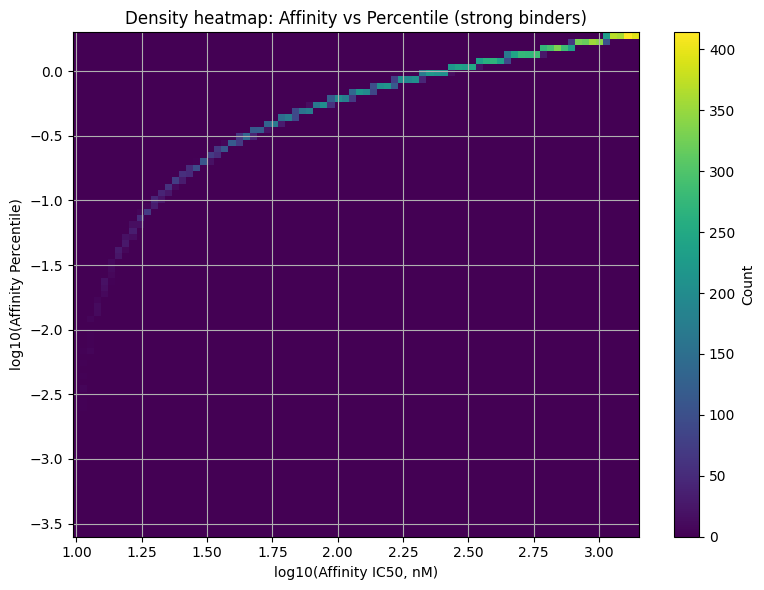

In [11]:

# axes: log10(IC50) vs log10(percentile)
x = np.log10(strong["mhcflurry_affinity"].astype(float))
y = np.log10(strong["mhcflurry_affinity_percentile"].astype(float))

plt.figure()
plt.hist2d(x, y, bins=80)
plt.xlabel("log10(Affinity IC50, nM)")
plt.ylabel("log10(Affinity Percentile)")
plt.title("Density heatmap: Affinity vs Percentile (strong binders)")
cbar = plt.colorbar()
cbar.set_label("Count")
plt.tight_layout()
plt.savefig("density_affinity_percentile.png", dpi=300)
plt.show()


## Number of strong peptides by length

This bar plot shows how many strong-binding peptides (as defined by the filtering criteria) were identified for each peptide length.

X-axis: peptide length in amino acids (AA).

Y-axis: count of peptides passing the strong-binding filter.

Bars represent how frequently each peptide length occurs among the strong candidates.

# Interpretation:

If one length (e.g., 9-mers) dominates, it indicates that the HLA allele under study has a clear length preference.

This is expected for many HLA class I alleles (e.g., HLA-A*02:01 typically binds 9-mers most strongly).

Deviations from the expected distribution may highlight interesting features in the peptide dataset.

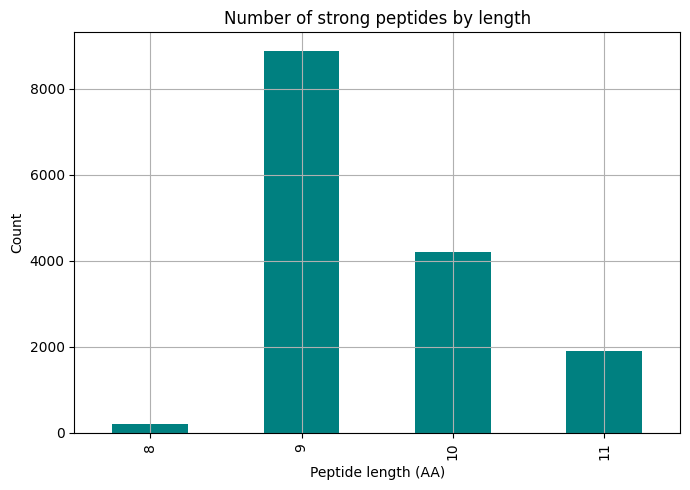

In [12]:
df_len = strong.copy()
df_len["peptide_len"] = df_len["peptide"].str.len()

counts = df_len["peptide_len"].value_counts().sort_index()

plt.figure(figsize=(7,5))
counts.plot(kind="bar", color="teal")
plt.xlabel("Peptide length (AA)")
plt.ylabel("Count")
plt.title("Number of strong peptides by length")
plt.tight_layout()
plt.show()


## Affinity distribution by peptide length

This boxplot shows how predicted binding affinities (IC50, nM) vary across peptides of different lengths (8–11 amino acids).

X-axis: peptide length (number of amino acids).

Y-axis: predicted binding affinity (IC50, log scale). Lower values indicate stronger binding.

Each box summarizes the distribution of affinities for peptides of a given length (median, interquartile range), while whiskers capture variability. Outliers are hidden for clarity.

# Interpretation:

If one peptide length consistently shows lower IC50 values, it suggests that this HLA allele has a length preference (e.g., HLA-A*02:01 is known to favor 9-mers).

Comparing distributions across lengths provides insights into which peptide sizes are more likely to contribute strong binders in the dataset.

C:\Users\amita\AppData\Local\Temp\ipykernel_4088\6083987.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_len, labels=lengths, showfliers=False)


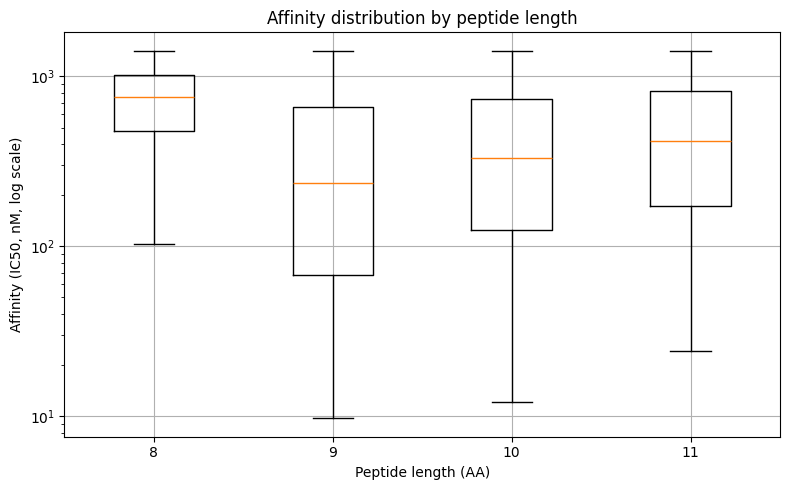

In [13]:
lengths = sorted(df_len["peptide_len"].unique())
data_by_len = [df_len.loc[df_len["peptide_len"] == L, "mhcflurry_affinity"].dropna()
               for L in lengths]

plt.figure(figsize=(8,5))
plt.boxplot(data_by_len, labels=lengths, showfliers=False)
plt.yscale("log")
plt.xlabel("Peptide length (AA)")
plt.ylabel("Affinity (IC50, nM, log scale)")
plt.title("Affinity distribution by peptide length")
plt.tight_layout()
plt.show()


# Correlation heatmap of prediction metrics

This heatmap shows the pairwise correlations between the main prediction outputs generated by MHCflurry:

mhcflurry_affinity – predicted binding affinity (IC50, nM).

mhcflurry_affinity_percentile – percentile rank of the predicted affinity relative to a background distribution.

mhcflurry_processing_score – likelihood that the peptide will be produced and transported for presentation.

mhcflurry_presentation_score – integrated score that combines processing, binding, and stability.

mhcflurry_presentation_percentile – percentile rank of the presentation score.

# Interpretation:

Strong positive correlations (red) indicate that two metrics tend to increase/decrease together.

Strong negative correlations (blue) indicate an inverse relationship.

Values near zero mean that the two metrics capture different, relatively independent aspects of peptide presentation.

This plot helps to understand whether the different metrics provide redundant information (highly correlated) or complementary signals (low correlation).

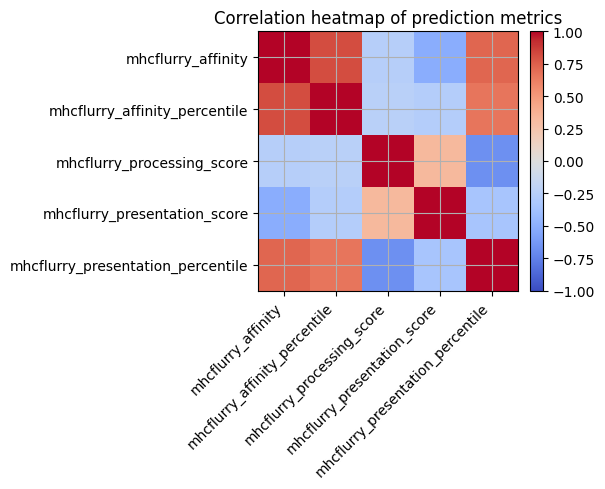

In [14]:
cols_of_interest = [
    'mhcflurry_affinity',
    'mhcflurry_affinity_percentile',
    'mhcflurry_processing_score',
    'mhcflurry_presentation_score',
    'mhcflurry_presentation_percentile'
]

df_corr = pred[cols_of_interest].corr()

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(df_corr.values, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(range(len(df_corr.columns)))
ax.set_yticks(range(len(df_corr.columns)))
ax.set_xticklabels(df_corr.columns, rotation=45, ha="right")
ax.set_yticklabels(df_corr.columns)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation heatmap of prediction metrics")
plt.tight_layout()
plt.show()
